In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import plotly.express as px
sns.set_theme(style='white')
import warnings
warnings.filterwarnings("ignore")

## 1. Data load, investigation and preparation

In [7]:
#file import from Rayhan's Mac
#from google.colab import drive
#drive.mount('/content/gdrive')

#file import from Pascal's Mac
from google.colab import files
uploaded = files.upload()

Saving hospital_mortality.csv to hospital_mortality.csv


In [8]:
# Read from Rayhan's Mac
#df = pd.read_csv('gdrive/My Drive/hospital_mortality.csv')
#df

# Read from Pascal's Mac
df=pd.read_csv('hospital_mortality.csv')
df.head(4)

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate,Systolic blood pressure,Diastolic blood pressure,Respiratory rate,temperature,SP O2,Urine output,hematocrit,RBC,MCH,MCHC,MCV,RDW,Leucocyte,Platelets,Neutrophils,Basophils,Lymphocyte,PT,INR,NT-proBNP,Creatine kinase,Creatinine,Urea nitrogen,glucose,Blood potassium,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,1,0,1,1,0,68.837838,155.866667,68.333333,16.621622,36.714286,98.394737,2155.0,26.272727,2.9600,28.2500,31.5200,89.900,16.2200,7.650,305.100,74.65,0.40,13.3,10.600000,1.000000,1956.0,148.0,1.958333,50.000000,114.636364,4.816667,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,1,0,0,0,1,101.370370,140.000000,65.000000,20.851852,36.682540,96.923077,1425.0,30.780000,3.1380,31.0600,31.6600,98.200,14.2600,12.740,246.400,NaN,NaN,NaN,NaN,NaN,2384.0,60.6,1.122222,20.333333,147.500000,4.450000,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,1,0,0,1,0,72.318182,135.333333,61.375000,23.640000,36.453704,95.291667,2425.0,27.700000,2.6200,34.3200,31.3000,109.800,23.8200,5.480,204.200,68.10,0.55,24.5,11.275000,0.950000,4081.0,16.0,1.871429,33.857143,149.000000,5.825000,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,0,0,0,0,0,94.500000,126.400000,73.200000,21.857143,36.287037,93.846154,8760.0,36.637500,4.2775,26.0625,30.4125,85.625,17.0375,8.225,216.375,81.80,0.15,14.5,27.066667,2.666667,668.0,85.0,0.585714,15.285714,128.250000,4.386667,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55


In [9]:
df.corr().outcome.sort_values()

Bicarbonate                -0.222650
Blood calcium              -0.184071
Urine output               -0.173135
PH                         -0.150611
Lymphocyte                 -0.138936
Systolic blood pressure    -0.132857
Renal failure              -0.108500
deficiencyanemias          -0.099513
temperature                -0.092861
Platelets                  -0.088465
Diastolic blood pressure   -0.087403
hypertensive               -0.072441
SP O2                      -0.071189
Blood sodium               -0.066366
BMI                        -0.062086
depression                 -0.060883
Hyperlipemia               -0.053466
diabetes                   -0.049997
PCO2                       -0.049517
COPD                       -0.047324
MCHC                       -0.031885
Basophils                  -0.026329
group                      -0.024220
EF                         -0.024138
RBC                        -0.023992
gendera                    -0.022690
hematocrit                 -0.016533
C

In [10]:
#search and drop value where more than 5% of the values are missing
missing = []
for col in df.columns:
  missing.append([col,df[col].isnull().sum()/df[col].sum()])

missing = pd.DataFrame(missing,columns=['cols','pct missing'])
missing.loc[missing['pct missing'] > 0.05]

,cols,pct missing
31,Basophils,0.695652
48,Lactic acid,0.130332


In [11]:
#df['Anion Gap'].hist()

### Finding No. 1: Large number of missing values for attributes Basophils and Lactic acid

Note: both variables with more than 5% missing data will be removed to prevent any bias in explanatory variables. Removal is further justified as follwed:
- Lactic Acid: Research shows increased lactic acid values correlate with the variable 'Anion Gap'. Since both parameters are available in the data, lactic acid can be removed
- Basophils: No significant correlation between Basophils and target attribute found (-0.026329)

In [12]:
#remove column where target 'outcome' is missing
df.outcome.isna().value_counts()
df = df.dropna(subset=['outcome'],axis=0)

In [13]:
#remove irrelevant columns and adjust binary/categorical labels
df=df.drop(['group','ID','Basophils','Lactic acid'],axis=1)
df['gendera']=df['gendera'].astype('object')
df['outcome'] = df['outcome'].astype('int64')
df['EF'] = df['EF'].astype('float64')
df.age=df.age.astype('float64')

In [14]:
#detect and remove outliers; code source: https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

for col in df.columns:
  df.col = remove_outlier(df,col)

# 2.Exploratory Data Analysis

In [15]:
high_cor=df.corr(method='pearson').outcome.sort_values(ascending=False).head(5)[1:]
low_cor=df.corr(method='pearson').outcome.sort_values(ascending=False).tail(6)[1:]
cor=pd.concat([high_cor,low_cor])
cor=pd.DataFrame(cor).reset_index()
cor=cor.rename(columns={'index':'Feature','outcome':'Pearson Correlation'})
cor['Pearson Correlation']=round(cor['Pearson Correlation'],3)


fig = px.bar(cor, x='Feature', y='Pearson Correlation',text='Pearson Correlation',
             title='Highest Correlations with Target Class',
             height=400,width=800)
fig.update_traces(marker_color='lightsalmon')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

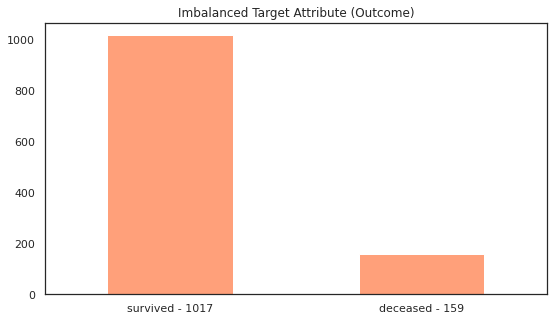

In [16]:
fig=plt.figure(figsize=(9,5))
df.outcome.replace([0,1],['survived - 1017','deceased - 159']).value_counts().plot(kind='bar', title='Imbalanced Target Attribute (Outcome)',color='lightsalmon')
plt.xticks(rotation=0)
plt.show()

In [17]:
deceased=df.outcome.value_counts()[1]
survived=df.outcome.value_counts()[0]
disbalance_ratio = round(deceased/(deceased+survived),2)
print('disbalance_ratio',disbalance_ratio)

disbalance_ratio 0.14


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8f9c80b90>,
      dtype=object)

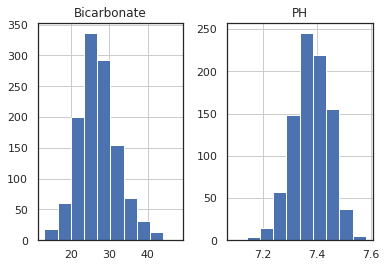

In [18]:
pos = df[["Bicarbonate", "PH"]]
pos.hist()

### Finding No. 2: Unbalanced Target Variable
Note: The target variable is disbalanaced and may lead to reduced model performance due to bias. This issue will be addressed by using randomized over-sampling (integrated into the pipelines)

# 3. Train Test Split

In [19]:
from sklearn.model_selection import train_test_split as ttf

y = df.outcome
x = df.drop(['outcome'],axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = ttf(x, y, train_size=0.8, test_size=0.2,random_state=0,stratify=y)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype == 'float64']

binary_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype == 'int64']

# Keep selected columns only
my_cols = categorical_cols + numerical_cols + binary_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

# 4. Building Processing Pipeline

## 4.1 Define Column Transformation

In [20]:
#define preprocessing strategies for numerical, categorical and binary attributes
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(missing_values=np.nan,strategy='median')),
    ('StandardScaler',StandardScaler())
])
                                         

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# Preprocessing for binary data
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='most_frequent'))
])

# Bundle preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('bin',binary_transformer, binary_cols)
    ])

In [21]:
#investigate preprocessing output
transformed_X_train = preprocessor.fit_transform(X_train,y_train)
test_transform=pd.DataFrame(data=transformed_X_train,columns=['age', 'BMI', 'heart rate', 'Systolic blood pressure',
       'Diastolic blood pressure', 'Respiratory rate', 'temperature', 'SP O2',
       'Urine output', 'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW',
       'Leucocyte', 'Platelets', 'Neutrophils', 'Lymphocyte', 'PT', 'INR',
       'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen',
       'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium',
       'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate', 'PCO2',
       'EF', 'gendera1','gendera2','hypertensive', 'atrialfibrillation', 'CHD with no MI',
       'diabetes', 'deficiencyanemias', 'depression', 'Hyperlipemia',
       'Renal failure', 'COPD'])
test_transform.head(2)

,age,BMI,heart rate,Systolic blood pressure,Diastolic blood pressure,Respiratory rate,temperature,SP O2,Urine output,hematocrit,RBC,MCH,MCHC,MCV,RDW,Leucocyte,Platelets,Neutrophils,Lymphocyte,PT,INR,NT-proBNP,Creatine kinase,Creatinine,Urea nitrogen,glucose,Blood potassium,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,PCO2,EF,gendera1,gendera2,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD
0,1.107468,-0.178869,-0.140791,-0.786390,-1.115714,-0.028896,-0.300889,1.037844,0.315466,-0.733425,-0.696608,-0.235073,-0.427649,-0.060221,-0.611097,-0.178552,0.744523,0.315678,0.038639,-0.319911,-0.345077,-0.266145,-0.122677,-0.374746,0.126332,-0.905406,1.429163,-0.804308,1.104182,-1.032282,-0.445343,-0.489337,-0.846179,0.770234,0.718054,0.471916,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,-1.372762,3.036721,0.741216,0.565259,0.404815,0.503213,0.377785,-0.183218,-0.077744,1.544647,1.491871,-0.616684,-0.949405,-0.234126,0.052085,0.163256,-0.023858,0.785567,-0.492620,-0.721968,-0.758441,-0.805515,-0.133337,-0.517160,-0.276680,0.160100,-0.117713,0.199048,1.683696,-1.489897,-0.623945,1.234415,0.308239,1.973576,2.250048,0.471916,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
test_transform.to_csv('hospital_mortality_transformed.csv')

## 4.2 Define Feature Selection Method and Over-Sampling  

In [22]:
#import models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

#import attribute selection methods
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVR, SVC

#import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

#import imbalanced learn strategies
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek


#define model and parameters
estimator = SVR(kernel="linear")

# Bundle preprocessing and modeling code in a pipeline
def buildPipelines (model):
  baseline_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)
                             ])
  oversamp_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('sampling', RandomOverSampler(random_state=100)),
                               ('model', model)
                             ])
  my_pipeline1 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('sampling', RandomOverSampler(random_state=100)),
                              ('feature_selection',VarianceThreshold(threshold=(.8 * (1 - .8)))),
                              ('model', model),
                             ])
  my_pipeline2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('sampling', RandomOverSampler(random_state=100)),
                              ('feature_selection',SelectKBest(f_classif, k=6)),
                              ('model', model),
                             ])
  my_pipeline3 = Pipeline(steps=[('preprocessor', preprocessor),
                               ('sampling', RandomOverSampler(random_state=100)),
                               ('feature_selection',SelectFromModel(ExtraTreesClassifier(n_estimators=50,criterion='gini',random_state=0))),
                              ('model', model)
                             ])
  my_pipeline4 = Pipeline(steps=[('preprocessor', preprocessor),
                               ('sampling', RandomOverSampler(random_state=100)),
                               ('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators=100,criterion='gini',random_state=0))),
                               ('model', model)
                             ])
  my_pipeline5 = Pipeline(steps=[('preprocessor', preprocessor),
                               ('sampling', RandomOverSampler(random_state=100)),
                               ('feature_selection', SelectFromModel(AdaBoostRegressor(random_state=0, n_estimators=30))),
                               ('model', model)
                             ])
  my_pipeline6 = Pipeline(steps=[('preprocessor', preprocessor),
                               ('sampling', RandomOverSampler(random_state=100)),
                               ('feature_selection', RFE(estimator=LogisticRegression(),n_features_to_select = 10, step = 1)),
                               ('model', model)
                             ])
  pipelines = [baseline_pipeline,oversamp_pipeline,my_pipeline1,my_pipeline2,my_pipeline3,my_pipeline4,my_pipeline5,my_pipeline6]
  return pipelines

## 4.3 Test and evaluate the Pipeline (Fit-Predict)

In [23]:
#fit-predict pipelines and return accuracy metrics
def fitPredictPipeline(my_pipeline):
  my_pipeline.fit(X_train, y_train)
  preds = my_pipeline.predict(X_valid)
  matrix = confusion_matrix(y_valid,preds)
  precision=precision_score(y_valid,preds)
  recall=recall_score(y_valid,preds)
  accuracy = accuracy_score(y_valid,preds)
  auc=roc_auc_score(y_valid,preds)
  cv_scores = cross_val_score(my_pipeline, x, y, cv=10,scoring='accuracy')
  mean_cv_score = cv_scores.mean()
  f1 = f1_score(y_valid,preds,average=None)[0]
  mcc=matthews_corrcoef(y_valid,preds)
  return precision,recall, accuracy,auc, mean_cv_score, f1,mcc, matrix,cv_scores, preds

# Evaluate each pipeline for a given model
def getModelEvaluation(model):
  pipline_print_labels = ['Baseline','Over_Sampling','VarianceThreshold','SelectKBest_(k=5)',
                          'ExtraTreesClassifier_n50','ExtraTreesClassifier_n100','Ada_Boosting','RFE']
  
  metrics=pd.DataFrame(data=[],columns=['precision','recall', 'accuracy','auc', 'mean_cv_score', 'f1','mcc'])
  i = 0
  for pipe in buildPipelines(model):
    precision,recall, accuracy,auc, mean_cv_score, f1,mcc, matrix, cv_scores, preds = fitPredictPipeline(pipe)
    metrics=metrics.append(pd.Series([precision,recall, accuracy,auc, mean_cv_score, f1,mcc],
                                     index=['precision','recall', 'accuracy','auc', 'mean_cv_score', 'f1','mcc'])
                                     ,ignore_index=True)
    i+=1
  return metrics

# 5. Model Selection and Training

## 5.1 Decision Tree Classifier

In [24]:
from sklearn.tree import DecisionTreeClassifier

#define model and hyper parameters
tree_model = DecisionTreeClassifier(random_state=0)

# fit pipelines and get evaluation metrics (accuarcy and cross validation accuarcy for each pipeline)
tree_metrics=getModelEvaluation(tree_model)

## 5.2 Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

#define model and hyper parameters
random_forest_model = RandomForestClassifier(random_state=0, n_estimators=100,criterion='gini',max_leaf_nodes=None)

# fit pipelines and get evaluation metrics (accuarcy and cross validation accuarcy for each pipeline)
rf_metrics=getModelEvaluation(random_forest_model)

## 5.3 Gaussian Naive Bayes Classifier

In [26]:
from sklearn.naive_bayes import GaussianNB

#define model and hyper parameters
n_bayes_model = GaussianNB()

# fit pipelines and get evaluation metrics (accuarcy and cross validation accuarcy for each pipeline)
nb_metrics=getModelEvaluation(n_bayes_model)

## 5.4 Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

#define model and hyper parameters
LR_model = LogisticRegression()

# fit pipelines and get evaluation metrics (accuarcy and cross validation accuarcy for each pipeline)
lr_metrics=getModelEvaluation(LR_model)

## 5.5 XGBoost Classifier

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

#define model and hyper parameters
xgb_clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,random_state=0,n_iter_no_change=5)

# fit pipelines and get evaluation metrics (accuarcy and cross validation accuarcy for each pipeline)
xgb_metrics=getModelEvaluation(xgb_clf)

## 5.6 Metrics

In [29]:
#concat all metrics into none data frame
tree_metrics['model']='tree'
rf_metrics['model']= 'random_f'
nb_metrics['model']= 'naive_bayes'
lr_metrics['model']= 'logistic_reg'
xgb_metrics['model']= 'xgb'
full_metrics=pd.concat([tree_metrics,rf_metrics,nb_metrics,lr_metrics,xgb_metrics])
full_metrics['pipe']=full_metrics.index

In [30]:
full_metrics.head()

,precision,recall,accuracy,auc,mean_cv_score,f1,mcc,model,pipe
0,0.324324,0.37500,0.809322,0.626225,0.793452,0.888337,0.237706,tree,0
1,0.281250,0.28125,0.805085,0.584252,0.803585,0.887255,0.168505,tree,1
2,0.351351,0.40625,0.817797,0.644301,0.804469,0.893300,0.271746,tree,2
3,0.333333,0.25000,0.830508,0.585784,0.806186,0.903846,0.194337,tree,3
4,0.270270,0.31250,0.792373,0.590074,0.801108,0.878412,0.169625,tree,4


## 6. Evaluation

### 6.1 Evaluation of Model Performance

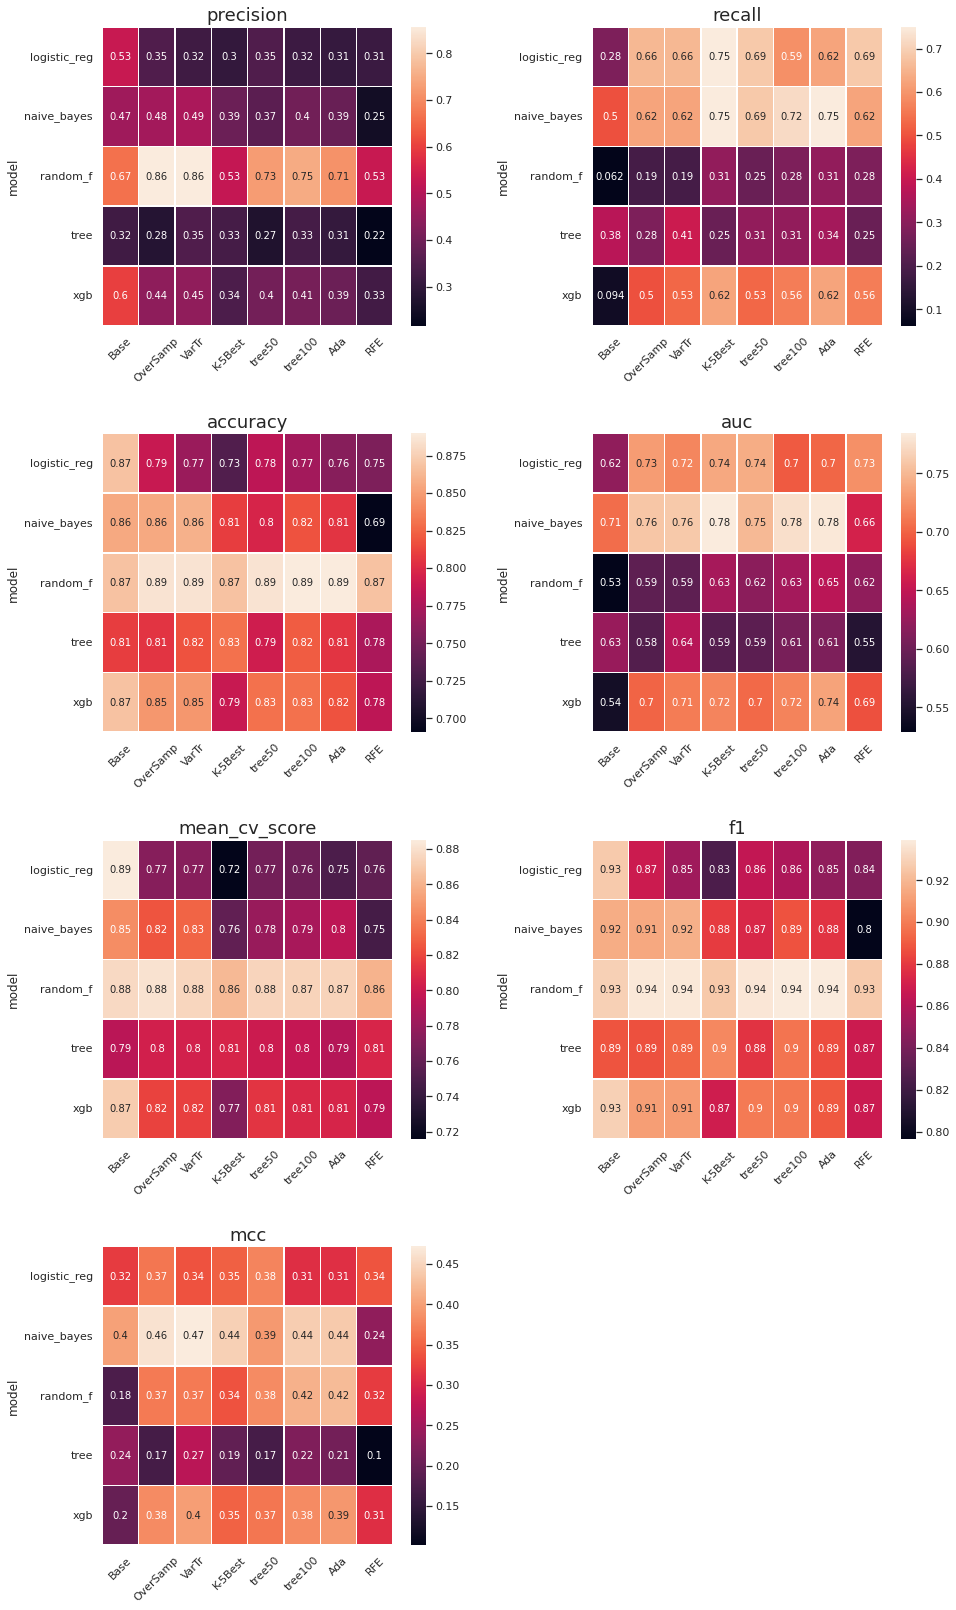

In [31]:
sns.color_palette("pastel", as_cmap=True)
fig = plt.figure(figsize=(14,23))
c=1
vls = ['precision','recall', 'accuracy','auc', 'mean_cv_score', 'f1','mcc']
for i in vls:
  pivot = pd.pivot_table(data=full_metrics,columns=['pipe'],
                           values=[i],index= 'model').rename(columns={0:'Base',1:'OverSamp',
                                                                               2:'VarTr',3:'K-5Best',
                                                                               4:'tree50',5:'tree100',
                                                                              6:'Ada',7:'RFE'})

  pivot.columns = [col[1] for col in pivot.columns]
  plt.subplot(4,2,c)
  sns.heatmap(data=pivot,annot=True,xticklabels=True,yticklabels=True, linewidths=.5)
  plt.xticks(rotation=45)
  plt.title(i).set_fontsize('18')
  c+=1
fig.show()
fig.tight_layout(pad=3.0)
fig.savefig('heatmap.png')

### 6.2 Evaluation of Feature Selection Methods

In [32]:
#evalute VarianceThreshold - Dropped features are [CHD with no MI,depression,COPD]
test_transform
selector=VarianceThreshold(threshold=(.8 * (1 - .8)))
pd.DataFrame(selector.fit_transform(test_transform)).head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,1.107468,-0.178869,-0.140791,-0.786390,-1.115714,-0.028896,-0.300889,1.037844,0.315466,-0.733425,-0.696608,-0.235073,-0.427649,-0.060221,-0.611097,-0.178552,0.744523,0.315678,0.038639,-0.319911,-0.345077,-0.266145,-0.122677,-0.374746,0.126332,-0.905406,1.429163,-0.804308,1.104182,-1.032282,-0.445343,-0.489337,-0.846179,0.770234,0.718054,0.471916,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,-1.372762,3.036721,0.741216,0.565259,0.404815,0.503213,0.377785,-0.183218,-0.077744,1.544647,1.491871,-0.616684,-0.949405,-0.234126,0.052085,0.163256,-0.023858,0.785567,-0.492620,-0.721968,-0.758441,-0.805515,-0.133337,-0.517160,-0.276680,0.160100,-0.117713,0.199048,1.683696,-1.489897,-0.623945,1.234415,0.308239,1.973576,2.250048,0.471916,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
#evaluate - Selected K-Best 6
selector=SelectKBest(f_classif, k=6)
selector.fit_transform(test_transform,y_train),
anova=pd.DataFrame(selector.scores_,index=test_transform.columns).sort_values(by=0,ascending=False).iloc[:6]
anova=anova.reset_index()
anova=anova.rename(columns={'index':'Feature',0:'F1-Test'})
fig = px.bar(anova, x='Feature', y='F1-Test',
             title='Feature Selection based on ANOVA F-Test (SelectKBest, k=6)',
             height=400,width=800)
fig.update_traces(marker_color='lightsalmon')
fig.show()

In [34]:
#evalute - ExtraTreeClf w. 50 Estimators - picks the 26 values with highest importance
clf=ExtraTreesClassifier(n_estimators=50,criterion='gini',random_state=0)
clf=clf.fit(test_transform,y_train)
selector=SelectFromModel(clf,prefit=True)
importance=pd.DataFrame(clf.feature_importances_)
transformed=pd.DataFrame(selector.transform(test_transform))
selected = importance.sort_values(by=0,ascending=False).iloc[:26]
selected_feature_names=list()
for i in selected.index:
  selected_feature_names.append(test_transform.columns[i])
selected['feature']= selected_feature_names
selected = selected.rename(columns={0:'Gini'})

#evalute - ExtraTreeClf w. 100 Estimators - picks the 27 values with highest importance
clf2=ExtraTreesClassifier(n_estimators=100,criterion='gini',random_state=0)
clf2=clf2.fit(test_transform,y_train)
selector=SelectFromModel(clf2,prefit=True)
importance=pd.DataFrame(clf2.feature_importances_)
transformed=pd.DataFrame(selector.transform(test_transform))
selected2 = importance.sort_values(by=0,ascending=False).iloc[:25]
selected_feature_names=list()
for i in selected2.index:
  selected_feature_names.append(test_transform.columns[i])
selected2['feature']= selected_feature_names
selected2 = selected2.rename(columns={0:'Gini'})

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=selected.feature,
    y=selected.Gini,
    name='50 Estimators',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=selected2.feature,
    y=selected2.Gini,
    name='100 Estimators',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45,title='Feature Selection with Extra Classifier with 50 and 100 estimators')
fig.show()

In [35]:
#evaluate AdA Boost - selects top 19 features
ada_clf=AdaBoostRegressor(random_state=0, n_estimators=30)
ada_clf=ada_clf.fit(test_transform,y_train)
importance=pd.DataFrame(ada_clf.feature_importances_,index=test_transform.columns)
importance=importance.sort_values(by=0,ascending=False).iloc[:19]
importance=importance.reset_index()
importance=importance.rename(columns={'index':'Feature',0:'Gini'})

fig = px.bar(importance, x='Feature', y='Gini',
             title='Feature Selection Ada Boost',
             height=400,width=800)
fig.update_traces(marker_color='lightsalmon')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [36]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()
clf=clf.fit(test_transform,y_train)
selector=RFE(estimator=clf,n_features_to_select = 10, step = 1)
selector=selector.fit(test_transform,y_train)
test_transform.columns[selector.get_support()]
coef=pd.DataFrame(clf.coef_).transpose()
coef['Feature']=test_transform.columns
coef=coef.rename(columns={0:'coef'})
coef=coef.sort_values(by='coef',ascending=False).iloc[:10]

fig=px.bar(coef,x='Feature',y='coef',title='Recursive Feature Elimination using Logistic Regression (k=10)',
           width=800,height=400)
fig.update_traces(marker_color='lightsalmon')
fig.update_layout(xaxis_tickangle=-45)
fig.show()